## **Preparo el entorno**

In [ ]:
!pip install pyCompare pingouin BaselineRemoval statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!rm -rf marvik-final/
!ls -la

total 16
drwxr-xr-x 1 root root 4096 Aug  5 17:09 .
drwxr-xr-x 1 root root 4096 Aug  5 16:50 ..
drwxr-xr-x 4 root root 4096 Aug  3 20:20 .config
drwxr-xr-x 1 root root 4096 Aug  3 20:21 sample_data


## **Librerías**



In [ ]:
# Importo las libreías necesarias
#
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.advanced_activations import LeakyReLU

from tensorflow.keras.optimizers import Adadelta, Adagrad, Adam, Adamax, Ftrl, Nadam, RMSprop, SGD

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Librerias para Bland-Altman
from pyCompare import blandAltman
import pingouin as pg
import statsmodels.api as sm

# Librería para corregir línea de base
from BaselineRemoval import BaselineRemoval

# Fijo una semilla para el generador de números pseudo aleatorios.
np.random.seed(1)
# 
np.set_printoptions(precision=3)

## **Importo los datos**

In [ ]:
# Clonamos el repositorio que contiene el archivo a ser usado:

! git clone https://github.com/tabareperez/marvik-final

# Queda disponible el archivo nic-az.csv para el desarrollo del modelo de predicción para nicotina y azúcar
# 

Cloning into 'marvik-final'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 22 (delta 8), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


In [ ]:
# Importamos al dataframe "data" nic-az.csv
#
data = pd.read_csv('./marvik-final/nic-az.csv')

# Revisamos los primeros registros
#
data.head()

,Sample ID,950,955,960,965,970,975,980,985,990,...,1620,1625,1630,1635,1640,1645,1650,Product Name,NIC,AZ
0,64127,0.171832,0.167635,0.163632,0.159960,0.156364,0.152704,0.149213,0.145870,0.142653,...,0.170383,0.169234,0.168183,0.167268,0.166693,0.166397,0.166621,BY-TOSTADO,3.42,2.3
1,64128,0.158099,0.154269,0.150645,0.147355,0.144167,0.140856,0.137698,0.134655,0.131734,...,0.168755,0.167463,0.166241,0.165137,0.164441,0.163915,0.163921,BY-TOSTADO,3.15,2.9
2,64129,0.147801,0.144223,0.140782,0.137600,0.134641,0.131533,0.128556,0.125714,0.122948,...,0.164203,0.162931,0.161710,0.160644,0.159961,0.159489,0.159452,BY-TOSTADO,3.17,2.6
3,64130,0.156667,0.152860,0.149220,0.145874,0.142716,0.139439,0.136297,0.133269,0.130398,...,0.165463,0.164344,0.163276,0.162332,0.161748,0.161411,0.161582,BY-TOSTADO,3.58,2.8
4,64131,0.156585,0.152820,0.149251,0.145938,0.142771,0.139458,0.136344,0.133299,0.130426,...,0.169477,0.168239,0.167031,0.165951,0.165254,0.164829,0.164926,BY-TOSTADO,3.56,2.9


## **Extraigo los espectros NIR (FEATURES)**

In [ ]:
features = data.drop(columns=['Sample ID', 'Product Name', 'NIC', 'AZ'],axis=1)
features.head()

,950,955,960,965,970,975,980,985,990,995,...,1605,1610,1615,1620,1625,1630,1635,1640,1645,1650
0,0.171832,0.167635,0.163632,0.159960,0.156364,0.152704,0.149213,0.145870,0.142653,0.139435,...,0.175053,0.173343,0.171665,0.170383,0.169234,0.168183,0.167268,0.166693,0.166397,0.166621
1,0.158099,0.154269,0.150645,0.147355,0.144167,0.140856,0.137698,0.134655,0.131734,0.128839,...,0.173823,0.171989,0.170202,0.168755,0.167463,0.166241,0.165137,0.164441,0.163915,0.163921
2,0.147801,0.144223,0.140782,0.137600,0.134641,0.131533,0.128556,0.125714,0.122948,0.120195,...,0.169248,0.167431,0.165657,0.164203,0.162931,0.161710,0.160644,0.159961,0.159489,0.159452
3,0.156667,0.152860,0.149220,0.145874,0.142716,0.139439,0.136297,0.133269,0.130398,0.127533,...,0.170102,0.168402,0.166732,0.165463,0.164344,0.163276,0.162332,0.161748,0.161411,0.161582
4,0.156585,0.152820,0.149251,0.145938,0.142771,0.139458,0.136344,0.133299,0.130426,0.127535,...,0.174491,0.172663,0.170898,0.169477,0.168239,0.167031,0.165951,0.165254,0.164829,0.164926


## **Gráficos de los primeros 20 espectros del set que conforman las features del problema**

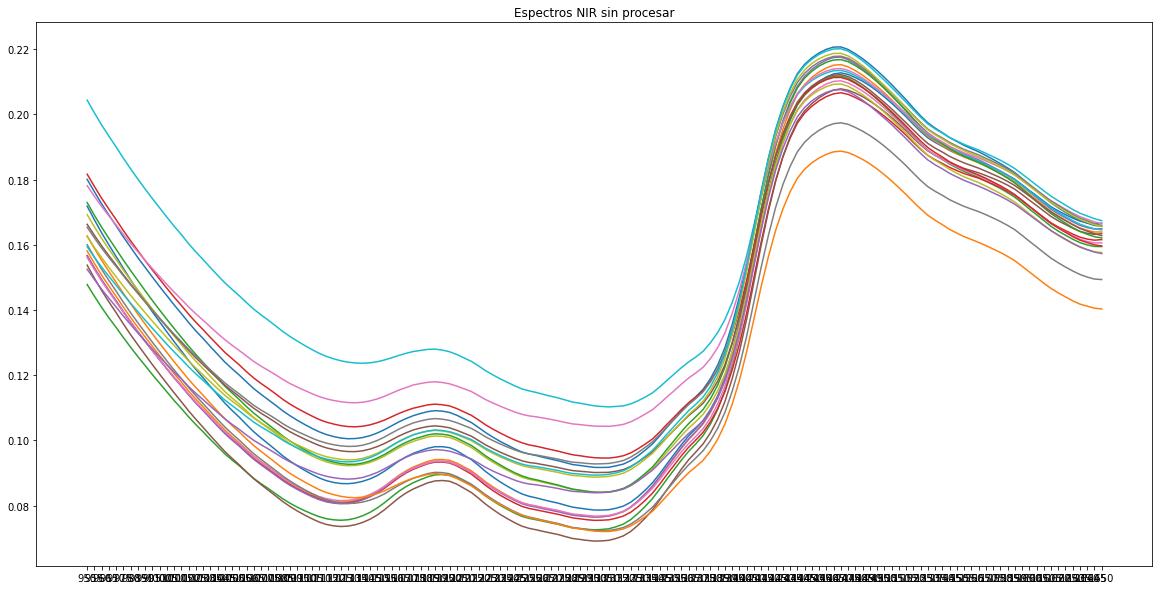

In [ ]:
# Ploteo los primeros 20 espectros crudos.
plt.rcParams["figure.figsize"] = (20,10)
plt.title('Espectros NIR sin procesar')
for i in range(20):
  spec = features.iloc[i,:]
  plt.plot(spec)

plt.show()


## **Variable: NICOTINA**

In [ ]:
target_nic = data[['NIC']]
target_nic.head()

,NIC
0,3.42
1,3.15
2,3.17
3,3.58
4,3.56


## **Distribución Nicotina**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f32bcbe6810>]],
      dtype=object)

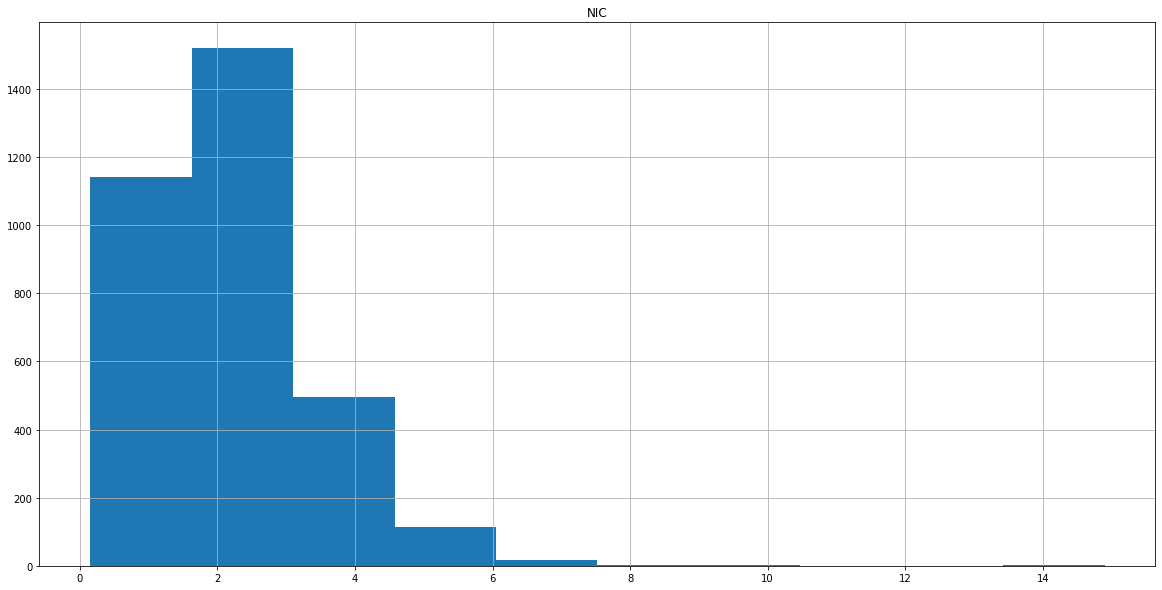

In [ ]:
target_nic.hist()

## **Preparo los sets de entrenamiento y test**

In [ ]:
train_features, test_features, train_target_nic, test_target_nic = train_test_split(features, target_nic, test_size=0.3, random_state=0)

## **Construyo el modelo para NICOTINA**

In [ ]:
no_features_columns = len(train_features.keys())
no_target_columns = len(train_target_nic.keys())

# Prueba #0
#model_nic = Sequential()
#model_nic.add(Dense(1,input_shape=[no_features_columns], activation = 'linear'))

# Prueba #1
#model_nic = Sequential()
#model_nic.add(Dense(32,activation='relu',input_shape=[no_features_columns]))
#model_nic.add(Dense(16, activation='relu'))
#model_nic.add(Dense(no_target_columns))

# Prueba #2
model_nic = Sequential()
model_nic.add(Dense(64,activation='relu',input_shape=[no_features_columns]))
model_nic.add(Dense(32, activation='relu'))
model_nic.add(Dense(16, activation='relu'))
model_nic.add(Dense(no_target_columns, activation='relu'))

# Prueba #3
#model_nic = Sequential()
#model_nic.add(Dense(64,input_shape=[no_features_columns], activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(32, activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(16, activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(8, activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(4, activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(2, activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(no_target_columns, activation = 'linear'))

# Prueba #4
#model_nic = Sequential()
#model_nic.add(Dense(64,input_shape=[no_features_columns], activation = 'relu'))
#model_nic.add(Dense(32, activation = 'relu'))
#model_nic.add(Dense(16, activation = 'relu'))
#model_nic.add(Dense(8, activation = 'relu'))
#model_nic.add(Dense(4, activation = 'relu'))
#model_nic.add(Dense(2, activation = 'relu'))
#model_nic.add(Dense(no_target_columns, activation = 'linear'))

## **Arquitectura del modelo para NICOTINA**

In [ ]:
model_nic.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                9088      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 11,713
Trainable params: 11,713
Non-trainable params: 0
_________________________________________________________________


## **Compilo el modelo**

In [ ]:
lr = 0.01
epochs = 200
#optimizer = Adadelta(learning_rate=lr, decay=lr/epochs)
#optimizer = Adagrad(learning_rate=lr, decay=lr/epochs)
#optimizer = Adam(learning_rate=lr, decay=lr/epochs)
#optimizer = Adamax(learning_rate=lr, decay=lr/epochs)
#optimizer = Ftrl(learning_rate=lr, decay=lr/epochs)
#optimizer = Nadam(learning_rate=lr, decay=lr/epochs)
optimizer = RMSprop(learning_rate=lr, decay=lr/epochs)
#optimizer = SGD(learning_rate=lr, decay=lr/epochs)
model_nic.compile(loss = 'mse', optimizer = optimizer, metrics=['mse', 'mae', 'mape'])

## **Entreno el modelo: NICOTINA**

In [ ]:
history = model_nic.fit(train_features,train_target_nic,batch_size=25, epochs=epochs)

Epoch 1/200
93/93 [==============================] - 1s 2ms/step - loss: 1.6242 - mse: 1.6242 - mae: 0.9887 - mape: 62.2893
Epoch 2/200
93/93 [==============================] - 0s 2ms/step - loss: 1.4304 - mse: 1.4304 - mae: 0.9231 - mape: 58.2881
Epoch 3/200
93/93 [==============================] - 0s 2ms/step - loss: 1.3721 - mse: 1.3721 - mae: 0.9075 - mape: 57.2000
Epoch 4/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2257 - mse: 1.2257 - mae: 0.8300 - mape: 50.7250
Epoch 5/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1718 - mse: 1.1718 - mae: 0.7939 - mape: 46.6162
Epoch 6/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1029 - mse: 1.1029 - mae: 0.7655 - mape: 44.3825
Epoch 7/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0577 - mse: 1.0577 - mae: 0.7401 - mape: 42.2984
Epoch 8/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0196 - mse: 1.0196 - mae: 0.7291 - mape: 41.5596
Epoch 9/

### **Grafico las métricas del modelo para NICOTINA con los espectros sin corregir**

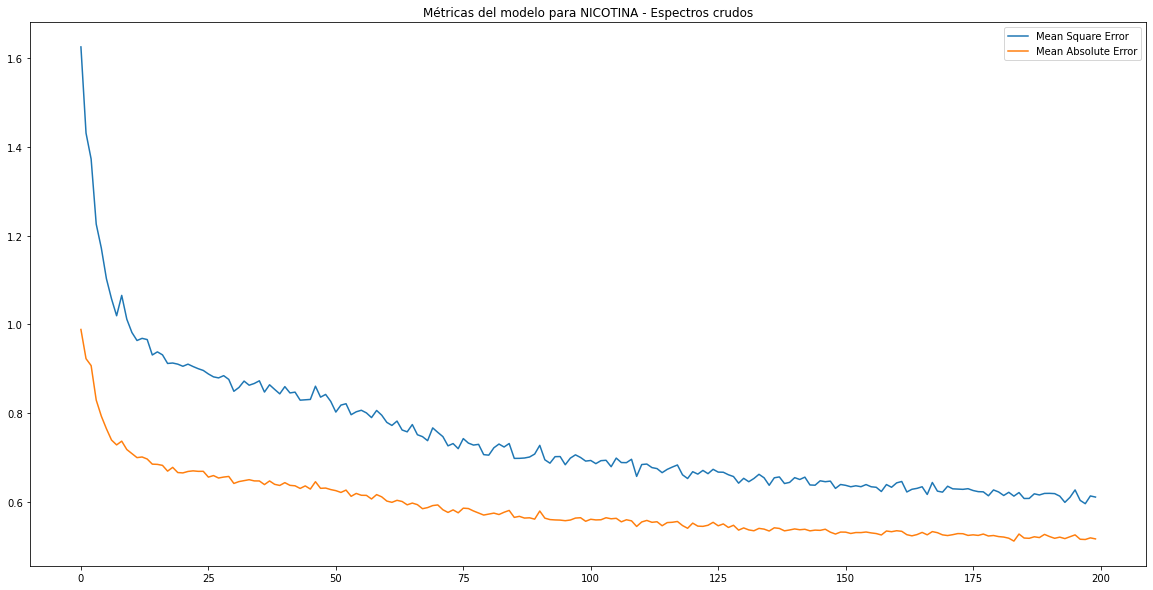

In [ ]:
# plot metrics
plt.title('Métricas del modelo para NICOTINA - Espectros crudos')
plt.plot(history.history['mse'], label = 'Mean Square Error')
plt.plot(history.history['mae'], label = 'Mean Absolute Error')
plt.legend(loc='best')
plt.show()

## **Predicciones: NICOTINA**

In [ ]:
test_predictions_nic = model_nic.predict(test_features)


## **Evaluación de la predicción de NICOTINA: Bland-Altman**

,PREDNIC,NIC
PREDNIC,1.000000,0.644772
NIC,0.644772,1.000000


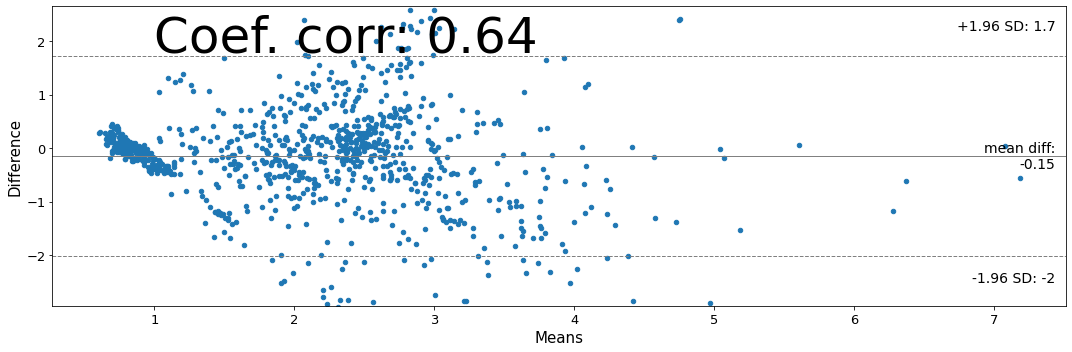

In [ ]:
# Armo un dataframe para graficar
pred_nic = test_predictions_nic
actual_nic= test_target_nic.to_numpy()
ba = np.concatenate((pred_nic, actual_nic), axis=1)
dfba = pd.DataFrame(ba, columns = ['PREDNIC', 'NIC'])

# Grafico Bland-Altman
f, ax = plt.subplots(1, figsize = (15, 5))
sm.graphics.mean_diff_plot(dfba.PREDNIC, dfba.NIC, ax = ax)
plt.text(1, 1.8, "Coef. corr: 0.64", fontsize=50)
plt.show

# Correlación
dfba.corr()

## **Corrijo línea de base**

In [ ]:
# Armo la matriz de espectros corregidos por línea de base
polynomial_degree=2 # Only needed for Modpoly and IModPoly algorithm
specObj=BaselineRemoval(features)

# Para recorrer todos los espectros: len(data)
features_bl = features
for i in range(len(data)):
  spec = features.iloc[i,:]
  specObj=BaselineRemoval(spec)
  spec_corregido = specObj.ModPoly(polynomial_degree)
  features_bl.loc[i] = spec_corregido

In [ ]:
# Le sumo el mínimo de las absorbancias corregidas para no tener valores negativos que provocan problemas de entrenamiento
offset = features_bl.min().min()
print('Offset para sumar:',offset)
features_corregido=features_bl.add(-offset)
print('Features corregido shape:',features_corregido.shape)
print('Mínimo de los features corregidos por offset:',features_corregido.min().min())

Offset para sumar: -0.0004878989807834272
Features corregido shape: (3293, 141)
Mínimo de los features corregidos por offset: 0.0


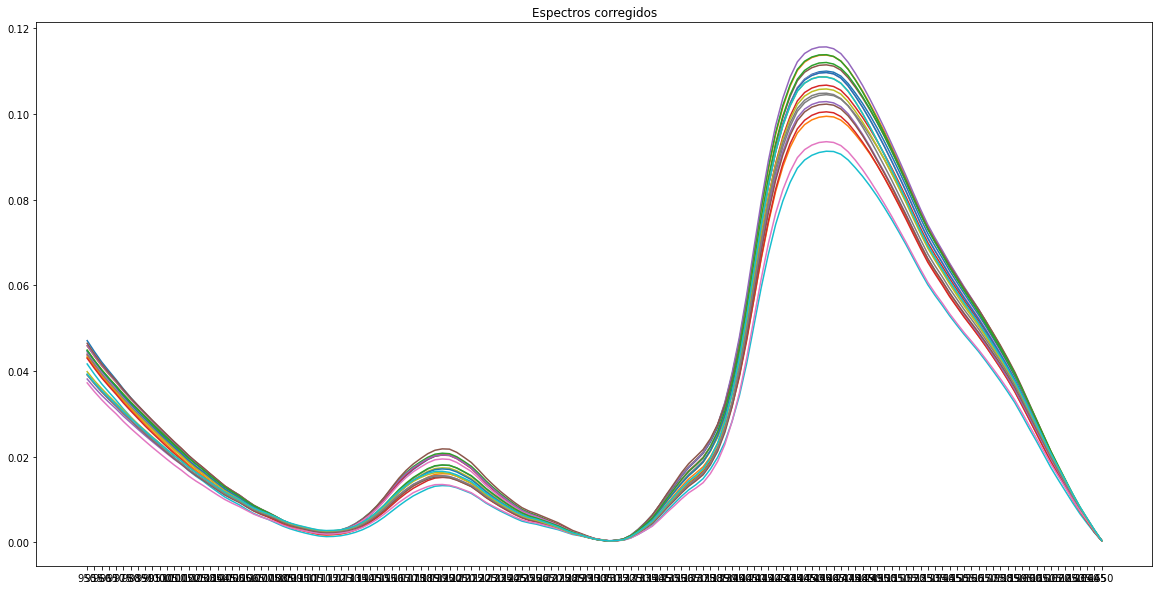

In [ ]:
# Ploteo los primeros 20 espectros con corrección de línea de base.
plt.rcParams["figure.figsize"] = (20,10)
plt.title('Espectros corregidos')
for i in range(20):
  spec_corregido = features_corregido.iloc[i,:]
  plt.plot(spec_corregido)

plt.show()


In [ ]:
train_features, test_features, train_target_nic, test_target_nic = train_test_split(features_corregido, target_nic, test_size=0.3, random_state=0)

In [ ]:
no_features_columns = len(train_features.keys())
no_target_columns = len(train_target_nic.keys())

# Prueba #0
#model_nic = Sequential()
#model_nic.add(Dense(1,input_shape=[no_features_columns], activation = 'linear'))

# Prueba #1
#model_nic = Sequential()
#model_nic.add(Dense(32,activation='relu',input_shape=[no_features_columns]))
#model_nic.add(Dense(16, activation='relu'))
#model_nic.add(Dense(no_target_columns))

# Prueba #2
model_nic = Sequential()
model_nic.add(Dense(64,activation='relu',input_shape=[no_features_columns]))
model_nic.add(Dense(32, activation='relu'))
model_nic.add(Dense(16, activation='relu'))
model_nic.add(Dense(no_target_columns, activation='relu'))

# Prueba #3
#model_nic = Sequential()
#model_nic.add(Dense(64,input_shape=[no_features_columns], activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(32, activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(16, activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(8, activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(4, activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(2, activation = 'selu', kernel_initializer='lecun_normal'))
#model_nic.add(Dense(no_target_columns, activation = 'linear'))

# Prueba #4
#model_nic = Sequential()
#model_nic.add(Dense(64,input_shape=[no_features_columns], activation = 'relu'))
#model_nic.add(Dense(32, activation = 'relu'))
#model_nic.add(Dense(16, activation = 'relu'))
#model_nic.add(Dense(8, activation = 'relu'))
#model_nic.add(Dense(4, activation = 'relu'))
#model_nic.add(Dense(2, activation = 'relu'))
#model_nic.add(Dense(no_target_columns, activation = 'linear'))

In [ ]:
model_nic.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                9088      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 16)                528       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 11,713
Trainable params: 11,713
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr = 0.01
epochs = 200
#optimizer = Adadelta(learning_rate=lr, decay=lr/epochs)
#optimizer = Adagrad(learning_rate=lr, decay=lr/epochs)
#optimizer = Adam(learning_rate=lr, decay=lr/epochs)
#optimizer = Adamax(learning_rate=lr, decay=lr/epochs)
#optimizer = Ftrl(learning_rate=lr, decay=lr/epochs)
#optimizer = Nadam(learning_rate=lr, decay=lr/epochs)
optimizer = RMSprop(learning_rate=lr, decay=lr/epochs)
#optimizer = SGD(learning_rate=lr, decay=lr/epochs)
model_nic.compile(loss = 'mse', optimizer = optimizer, metrics=['mse', 'mae', 'mape'])

In [ ]:
history = model_nic.fit(train_features,train_target_nic,batch_size=25, epochs=epochs)

Epoch 1/200
93/93 [==============================] - 1s 3ms/step - loss: 1.8022 - mse: 1.8022 - mae: 1.0182 - mape: 66.4414
Epoch 2/200
93/93 [==============================] - 0s 2ms/step - loss: 1.3491 - mse: 1.3491 - mae: 0.8620 - mape: 54.4100
Epoch 3/200
93/93 [==============================] - 0s 2ms/step - loss: 1.2630 - mse: 1.2630 - mae: 0.8213 - mape: 50.5882
Epoch 4/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1782 - mse: 1.1782 - mae: 0.7731 - mape: 45.7755
Epoch 5/200
93/93 [==============================] - 0s 2ms/step - loss: 1.1400 - mse: 1.1400 - mae: 0.7638 - mape: 45.5959
Epoch 6/200
93/93 [==============================] - 0s 2ms/step - loss: 1.0498 - mse: 1.0498 - mae: 0.7279 - mape: 42.5071
Epoch 7/200
93/93 [==============================] - 0s 2ms/step - loss: 0.9615 - mse: 0.9615 - mae: 0.6785 - mape: 38.4966
Epoch 8/200
93/93 [==============================] - 0s 2ms/step - loss: 0.9192 - mse: 0.9192 - mae: 0.6538 - mape: 36.0151
Epoch 9/

## **Grafico las métricas del modelo para NICOTINA con los espectros corregidos**

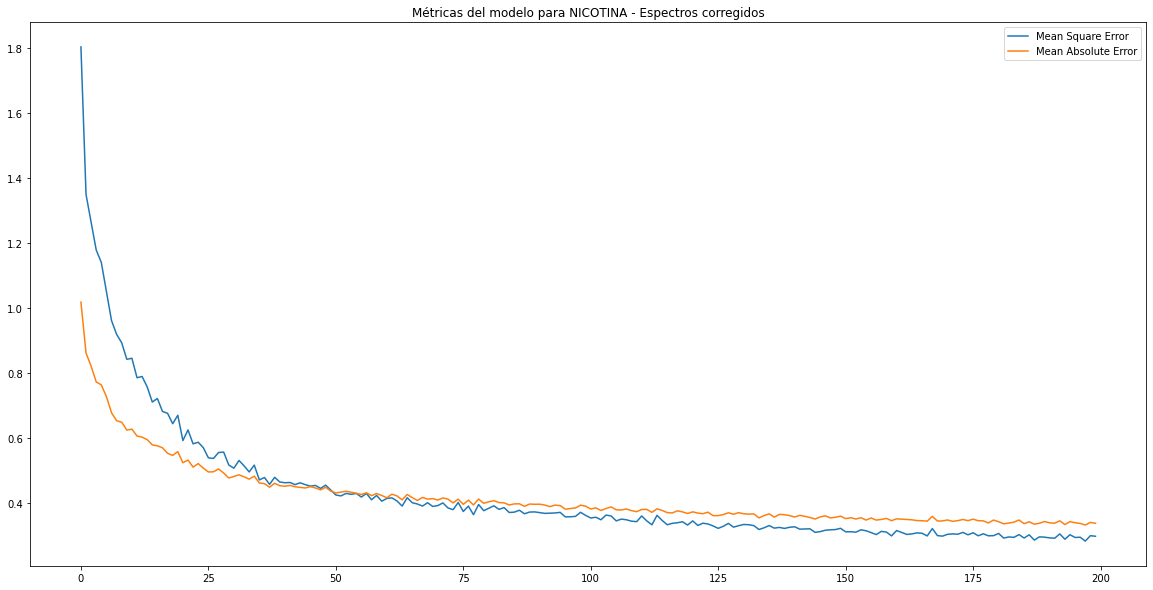

In [ ]:
# plot metrics
plt.title('Métricas del modelo para NICOTINA - Espectros corregidos')
plt.plot(history.history['mse'], label = 'Mean Square Error')
plt.plot(history.history['mae'], label = 'Mean Absolute Error')
plt.legend(loc='best')
plt.show()

## **Predicciones: NICOTINA**

In [ ]:
test_predictions_nic = model_nic.predict(test_features)

## **Evaluación de la predicción de NICOTINA: Bland-Altman**

,PREDNIC,NIC
PREDNIC,1.000000,0.930377
NIC,0.930377,1.000000


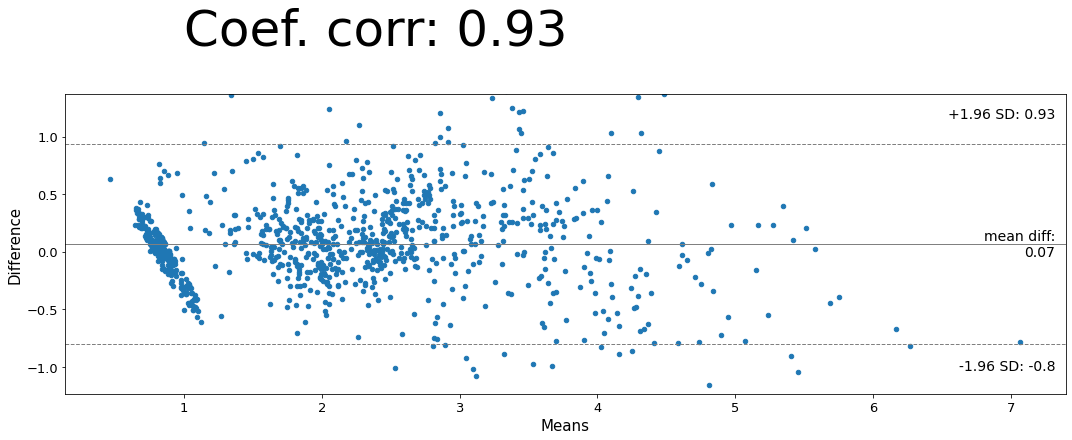

In [ ]:
# Armo un dataframe para graficar
pred_nic = test_predictions_nic
actual_nic= test_target_nic.to_numpy()
ba = np.concatenate((pred_nic, actual_nic), axis=1)
dfba = pd.DataFrame(ba, columns = ['PREDNIC', 'NIC'])

# Grafico Bland-Altman
f, ax = plt.subplots(1, figsize = (15, 5))
sm.graphics.mean_diff_plot(dfba.PREDNIC, dfba.NIC, ax = ax)
plt.text(1, 1.8, "Coef. corr: 0.93", fontsize=50)
plt.show

# Correlación
dfba.corr()